<a href="https://colab.research.google.com/github/Sentinel-FYP/colab_notebooks/blob/main/sentinel_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Dependencies and Set Constants

### Install Dependencies

In [ ]:
!pip install tf-models-official

### Import Packages

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import zipfile as zf
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from itertools import cycle

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

### Set Hyperparams

In [ ]:
num_classes = 2
batch_size = 1
resolution = 172
num_frames = 100
frame_step = 10
epochs = 10
model_id = 'a0'
export_model = True
start_from_checkpoint = True
evaluate = True
export_model_name = 'a0_stream_4.0'
frame_shape = (num_frames, resolution, resolution, 3)
input_shape = (batch_size, num_frames, resolution, resolution, 3)

### Create Directory Structure

In [ ]:
paths = {}
paths['root'] = pathlib.Path('/content/drive/MyDrive/ucf_dataset')
assert paths['root'].exists() == True
paths['models'] = (paths['root'] / 'models' / model_id)
paths['tflite'] = (paths['root'] / 'tf_lite_models' / model_id)
paths['checkpoints_dir'] = (paths['root'] / 'checkpoints' / model_id / export_model_name)

In [ ]:
for p in paths.values():
  assert p.exists() == True

## Load Data

### Load Annotations

In [ ]:
annotations = pd.read_csv(paths['root'] / 'frame_annotations.csv')
annotations = annotations.set_index('file_name')
annotations['binary_class'] = annotations['is_annomaly'].map({1.0 : 'Anomaly', 0.0 : "Normal"})

### Define Helper Functions

In [ ]:
def get_class(fname):
  """ Retrieve the name of the class given a filename/file_path.

    Args:
      fname: Name of the file in the UCF Crime dataset.
    Returns:
      Class that the file belongs to.
  """
  fname = fname.split('/')[-1]
  class_name = fname.split('_')[0]
  #remove numbers
  class_name = ''.join(char for char in class_name if not char.isnumeric())
  if class_name == "Normal":
    return "Normal"
  else:
    return "Anomaly"

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [ ]:
def get_video_annotations(video_path, annotations_df=annotations):
  video_name = str(video_path).split("/")[-1]
  return annotations_df.loc[video_name].to_dict()

In [ ]:
def frames_from_video_file(video_path, n_frames, output_size, frame_step):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  video_annotations = get_video_annotations(video_path)
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  need_length = 1 + (n_frames - 1) * frame_step
  if video_annotations['anomaly_1_start'] == -1:
    if need_length > video_length:
      start = 0
      end = video_length
    else:
      max_start = video_length - need_length
      start = random.randint(0, max_start + 1)
      end = start + need_length
  else:
    start = video_annotations['anomaly_1_start']
    end = video_annotations['anomaly_1_end']
  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  frame_count = start + 1;
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
      frame_count += 1;
    if ret and frame_count < end and frame is not None:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      break
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

### Create Dataset Paths

In [ ]:
dataset_paths = {}
dataset_directory = pathlib.Path('/content/drive/MyDrive/ucf_extracted')
dataset_paths['train'] = dataset_directory / 'train'
dataset_paths['test'] = dataset_directory / 'test'

In [ ]:
for p in dataset_paths.values():
  assert p.exists() == True

### Create Dataset Generator


In [ ]:
class FrameGenerator:
  def __init__(self, path, n_frames=num_frames, output_size=(resolution, resolution), frame_step=frame_step, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.output_size = output_size
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()
    pairs = list(zip(video_paths, classes))
    if self.training:
      random.shuffle(pairs)
    for path, name in pairs:
      try:
        video_frames = frames_from_video_file(path, self.n_frames, output_size=self.output_size, frame_step=frame_step)
      except Exception as exc:
        print(f'Error on {path}')
        print(exc)
        continue
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label


In [ ]:
output_signature = (tf.TensorSpec(shape =(None, resolution, resolution, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_fg = FrameGenerator(dataset_paths['train'])
train_ds = tf.data.Dataset.from_generator(train_fg,
                                          output_signature=output_signature
                                          )
train_ds = train_ds.batch(batch_size)

test_fg = FrameGenerator(dataset_paths['test'])
test_ds = tf.data.Dataset.from_generator(test_fg,
                                        output_signature=output_signature
                                         )
test_ds = test_ds.batch(batch_size)

## Load Batch Model

### Construct the backbone with proper parameters

In [ ]:
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}

backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=False,
)

### Set up the distribution strategy

In [ ]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  distribution_strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

print("Number of accelerators: ", distribution_strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


### Construct custom classifier with required number of classes

In [ ]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, None, resolution, resolution, 3])

  return model

# Construct loss, optimizer and compile the model
with distribution_strategy.scope():
  batch_model = build_classifier(batch_size, num_frames, resolution, backbone, num_classes)
  loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
  batch_model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

### Start From Previous Checkpoint

In [ ]:
batch_model.load_weights(tf.train.latest_checkpoint(paths['checkpoints_dir']))

In [ ]:
def plot_roc(actual_labels, probs, set_name, n_classes=2, classes=['Anomaly', 'Normal']):
  plt.figure(figsize=(8,8))
  actual_labels = np.array(actual_labels).astype(int)
  probs = np.array(probs).astype(int)
  y_one_hot = tf.one_hot(actual_labels, depth=n_classes)
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  lw = 2
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_one_hot[:, i], probs[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(classes[i], roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {set_name}')
  plt.legend(loc="lower right")
  plt.show()


## Evaluation

### Plot Confusion Matrix

In [ ]:
def get_actual_predicted_labels(dataset, model):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  probs = tf.nn.softmax(predicted)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted, probs

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  plt.figure(figsize=(8,8))
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

## Evaluate Sets


In [ ]:
def get_accuracy(actual, predicted):
  actual = np.array(actual).astype(int)
  predicted = np.array(predicted).astype(int)
  total_correct = len(actual[actual == predicted])
  return (total_correct / len(actual)) * 100

In [ ]:
# def plot_roc(actual, predicted, set_name):
#   fig, ax = plt.subplots()
#   fig.set_figheight(8)
#   fig.set_figwidth(8)
#   fpr_keras, tpr_keras, thresholds_keras = roc_curve(actual, predicted)
#   auc_keras = auc(fpr_keras, tpr_keras)
#   ax.plot([0, 1], [0, 1], 'k--')
#   ax.plot(fpr_keras, tpr_keras, label='Anomaly (area = {:.3f})'.format(auc_keras))
#   ax.set_xlabel('False positive rate')
#   ax.set_ylabel('True positive rate')
#   ax.set_title(f'ROC Curve for {set_name}')
#   ax.legend(loc='best')

In [ ]:
%matplotlib inline
def evaluate_set(set_name, save_results_to, dataset, fg):
  files, class_names = fg.get_files_and_class_names()
  label_names = list(fg.class_ids_for_name.keys())
  actual, predicted, probs = get_actual_predicted_labels(dataset, batch_model)
  plot_confusion_matrix(actual, predicted, label_names, set_name)
  results = pd.DataFrame({'actual' : actual,
                          'predicted' : predicted,
                          'file': files,
                          'class': class_names
                          })
  results.to_csv(save_results_to, index=False)
  print(f"Accuracy of {set_name} set is: {get_accuracy(actual, predicted)}")
  return actual, predicted, probs

In [ ]:
results_dir = paths['root']/'results'/export_model_name
results_dir.mkdir(parents=True, exist_ok=True)

150/150 [==============================] - 215s 1s/step
Accuracy of test set is: 76.66666666666667


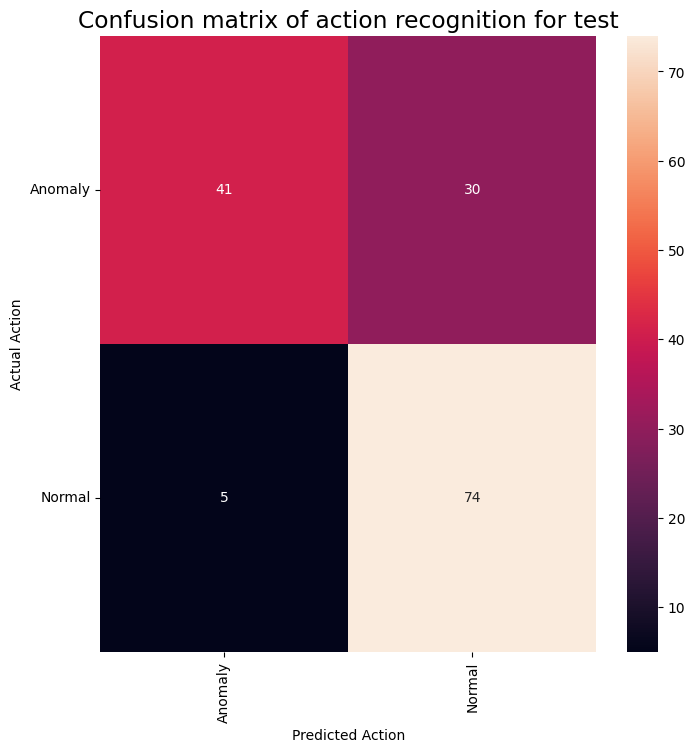

In [ ]:
actual, predicted, probs = evaluate_set('test', save_results_to=results_dir/'test.csv', dataset=test_ds, fg=test_fg)

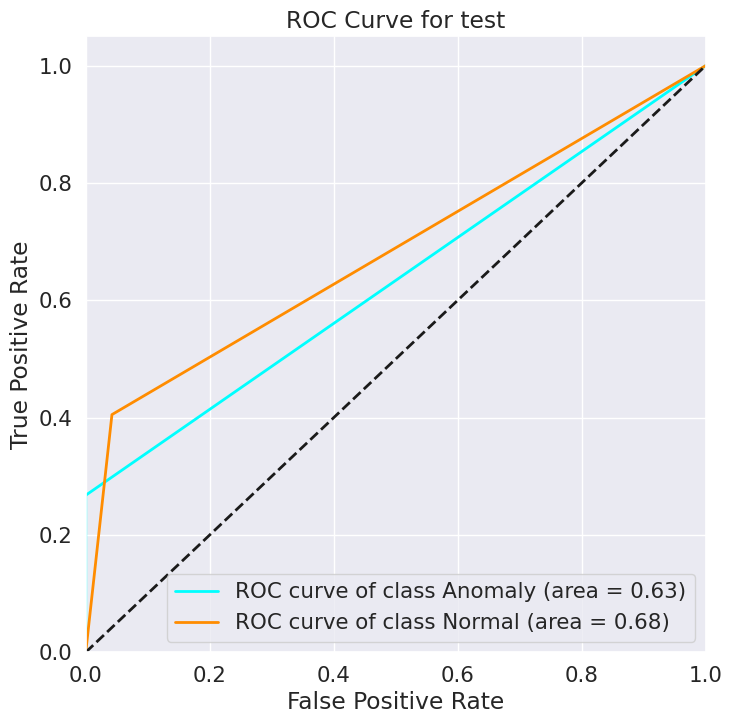

In [ ]:
plot_roc(actual, probs, "test")

In [ ]:
def validate_df(df):
  assert len(df[df['actual'] == 0]) == len(df[df['class'] == 'Anomaly'])
  assert len(df[df['actual'] == 1]) == len(df[df['class'] == 'Normal'])

In [ ]:
validate_df(pd.read_csv(results_dir/'test.csv'))

849/849 [==============================] - 1579s 2s/step
Accuracy of train set is: 81.62544169611307


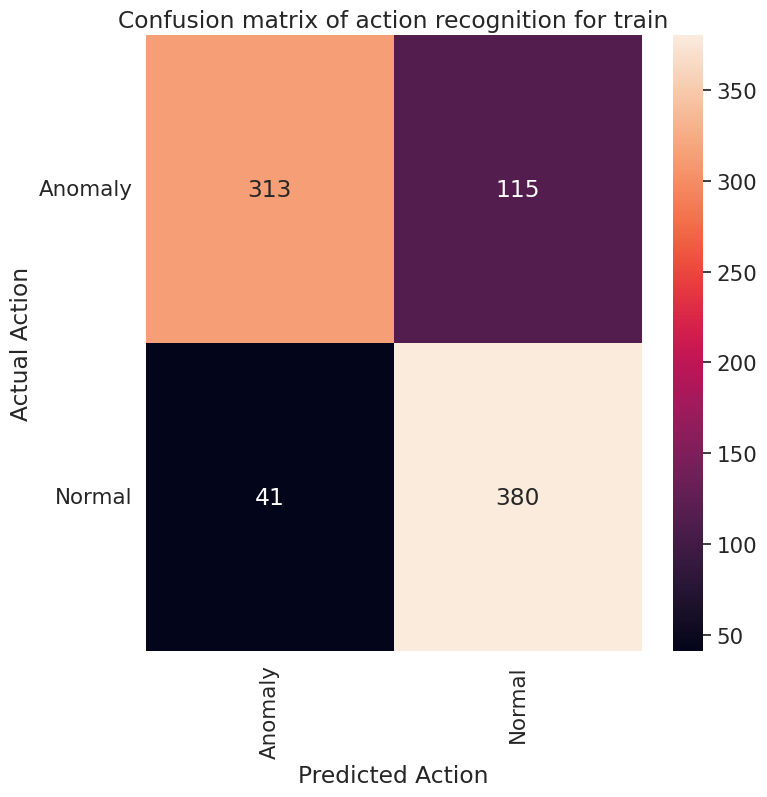

In [ ]:
actual_train, predicted_train, probs_train = evaluate_set('train', save_results_to=results_dir/'train.csv', dataset=train_ds, fg=train_fg)

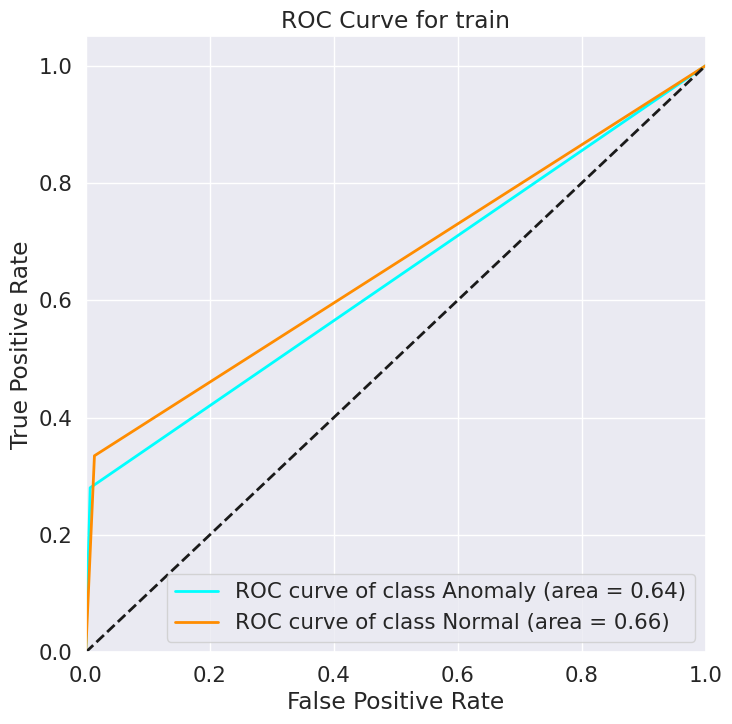

In [ ]:
plot_roc(actual_train, probs_train, "train")

In [ ]:
validate_df(pd.read_csv(results_dir/'train.csv'))